### Linear Regression - Interpreting the result
In this notebook we use linear regression to predict the coefficients corresponding to the top eigenvectors of the measurements:
* TAVG: The average temperature for day/location. (TMAX + TMIN)/2
* TRANGE: The temperature range between the highest and lowest temperatures of the day. TMAX-TMIN.
* SNWD: The depth of the accumulated snow.

These 9 variables are the output variables that we aim to predict.

The 4 input variables we use for the regression are properties of the location of the station:
* latitude, longitude: location of the station.
* elevation: the elevation of the location above sea level.
* dist_coast: the distance of the station from the coast (in kilometers).

### Read and parse the data

In [1]:
import pickle
import pandas as pd
!ls *.pickle  # check 

stations_projections.pickle


In [2]:
!curl -o "stations_projections.pickle" "http://mas-dse-open.s3.amazonaws.com/Weather/stations_projections.pickle"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2750k  100 2750k    0     0  1932k      0  0:00:01  0:00:01 --:--:-- 1931k


In [2]:
data = pickle.load(open("stations_projections.pickle",'r'))
data.shape

(12140, 8)

In [3]:
data.head(1)

,station,TAVG_coeff,TRANGE_coeff,SNWD_coeff,latitude,longitude,elevation,dist_coast
0,USC00044534,"[3047.96236332, 1974.34852034, 150.560792408]","[-2903.63287861, -236.907267527, 147.021790682]","[0.19150300062, 0.187262808215, -0.0401379552536]",36.0042,-119.96,73.2,107.655


In [4]:
# break up the lists of coefficients separate columns
for col in [u'TAVG_coeff', u'TRANGE_coeff', u'SNWD_coeff']:
    for i in range(3):
        new_col=col+str(i+1)
        data[new_col]=[e[i] for e in list(data[col])]
    data.drop(labels=col,axis=1,inplace=True)
data.drop(labels='station',axis=1,inplace=True)
data.head(1)

,latitude,longitude,elevation,dist_coast,TAVG_coeff1,TAVG_coeff2,TAVG_coeff3,TRANGE_coeff1,TRANGE_coeff2,TRANGE_coeff3,SNWD_coeff1,SNWD_coeff2,SNWD_coeff3
0,36.0042,-119.96,73.2,107.655,3047.962363,1974.34852,150.560792,-2903.632879,-236.907268,147.021791,0.191503,0.187263,-0.040138


### Performing and evaluating the regression
As the size of the data is modest, we can perform the regression using regular python (not spark) running on a laptop. We use the library `sklearn`

In [5]:
from sklearn.linear_model import LinearRegression

### Coefficient of determination

Computed by calling the method `LinearRegression.score()`

The regression score comes under several names: "Coefficient of determination", $R^2$, "R squared score", "percentage of variance explained", "correlation coefficient". It is explained in more detail in [wikipedia](https://en.wikipedia.org/wiki/Coefficient_of_determination).

**Roughly speaking the $R^2$-score measures the fraction of the variance of the regression output variable that is explained by the prediction function.** The score varies between 0 and 1. A score of 1 means that the regression function perfectly predicts the value of $y$. A score of 0 means that it does not predict $y$ at all.

#### Training score vs Test score
Suppose we fit a regression function with 10 features to 10 data points. We are very likely to fit the data perfectly and get a score of 1. However, this does not mean that our model truly explains the data. It just means that the number of training examples we are using to fit the model is too small. To detect this situation, we can compute the score of the model that was fit to the **training set**, on a **test set**. If the ratio between the test score and the training score is smaller than, say, 0.1, then our regression function probably over-fits the data.

#### Finding the importance of input variables
The fact that a regression coefficient is far from zero provides some indication that it is important. However, the size of these coefficients also depends on the scaling of the variables. A much more reliable way to find out which of the input variables are important is to compare the score of the regression function we get when using all of the input variables to the score when one of the variables is eliminated. This is sometimes called "sensitivity analysis"

In [6]:
# Compute score changes
def compute_scores(y_label,X_Train,y_Train,X_test,Y_test):
    lg = LinearRegression()
    lg.fit(X_Train,y_Train)

    train_score = lg.score(X_Train,y_Train)
    test_score = lg.score(X_test,Y_test)
    print('R-squared(Coeff. of determination): Train:%.3f, Test:%.3f\n' % (train_score,test_score))

    full=set(range(X_Train.shape[1]))
    for i in range(X_Train.shape[1]):
        L=list(full.difference(set([i])))  # fill in
        L.sort()
        r_train_X=X_Train[:,L]
        r_test_X=X_test[:,L]
        
        lg = LinearRegression()
        lg.fit(r_train_X,y_Train)
        r_train_score = lg.score(r_train_X,y_Train)
        r_test_score  = lg.score(r_test_X,Y_test)
        print "removed",data.columns[i],
        print "Score decrease: \tTrain:%5.3f" % (train_score-r_train_score),
        print "\tTest: %5.3f " % (test_score-r_test_score)

### Partition into training set and test set
By dividing the data into two parts, we can detect when our model over-fits. When over-fitting happens, the significance on the test set is much smaller than the significance on the training set.

In [7]:
from numpy.random import rand
N=data.shape[0]
train_i = rand(N)>0.5
Train = data.ix[train_i,:]
Test  = data.ix[~train_i,:]   # fill in
print data.shape,Train.shape,Test.shape

(12140, 13) (6137, 13) (6003, 13)


In [8]:
from sklearn.cross_validation import train_test_split

train_X = Train.ix[:,:4].values
test_X=Test.ix[:,:4].values
input_names=list(data.columns[:4])   #['latitude', 'longitude', 'elevation', 'dist_coast']

for target in ["TAVG","TRANGE","SNWD"]:
    for j in range(1,4):
        y_label = target+"_coeff"+str(j)
        train_y = Train[y_label]
        test_y = Test[y_label]
        lg = LinearRegression()
        lg.fit(train_X,train_y)

        print "\nTarget variable: ", y_label, '#'*40
        print "Coeffs: ",\
            ' '.join(['%s:%5.2f ' % (input_names[i],lg.coef_[i]) for i in range(len(lg.coef_))])
        
        compute_scores(y_label, train_X, train_y, test_X, test_y)


Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-154.98  longitude:-19.29  elevation:-0.67  dist_coast:-0.14 
R-squared(Coeff. of determination): Train:0.930, Test:0.932

removed latitude Score decrease: 	Train:0.620 	Test: 0.605 
removed longitude Score decrease: 	Train:0.068 	Test: 0.065 
removed elevation Score decrease: 	Train:0.123 	Test: 0.126 
removed dist_coast Score decrease: 	Train:0.003 	Test: 0.003 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-5.88  longitude: 7.56  elevation:-0.14  dist_coast: 0.49 
R-squared(Coeff. of determination): Train:0.593, Test:0.595

removed latitude Score decrease: 	Train:0.010 	Test: 0.002 
removed longitude Score decrease: 	Train:0.117 	Test: 0.115 
removed elevation Score decrease: 	Train:0.064 	Test: 0.070 
removed dist_coast Score decrease: 	Train:0.382 	Test: 0.390 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


### Interpretation
When we find a statistically significant coefficient, we want to find a rational explanation for the significance and for the sign of the corresponding coefficient. Please write a one line explanation for each of the following nine input/output pairs (the ones that are numbered).

```
Target variable:  TAVG_coeff1 ########################################
Coeffs:  latitude:-153.98  longitude:-19.21  elevation:-0.68  dist_coast:-0.13 
R-squared(Coeff. of determination): Train:0.931, Test:0.931

1. removed latitude Score decrease: 	Train:0.613 	Test: 0.612 
2. removed elevation Score decrease: 	Train:0.128 	Test: 0.121 

Target variable:  TAVG_coeff2 ########################################
Coeffs:  latitude:-5.33  longitude: 7.46  elevation:-0.14  dist_coast: 0.48 
R-squared(Coeff. of determination): Train:0.603, Test:0.585

3. removed longitude Score decrease: 	Train:0.115 	Test: 0.116 
4. removed dist_coast Score decrease: 	Train:0.393 	Test: 0.378 

Target variable:  TAVG_coeff3 ########################################
Coeffs:  latitude:-4.19  longitude:-2.64  elevation: 0.01  dist_coast: 0.07 
R-squared(Coeff. of determination): Train:0.420, Test:0.398

5. removed longitude Score decrease: 	Train:0.148 	Test: 0.164 
6. removed dist_coast Score decrease: 	Train:0.095 	Test: 0.082 

Target variable:  TRANGE_coeff1 ########################################
Coeffs:  latitude:25.00  longitude: 8.63  elevation:-0.36  dist_coast:-0.15 
R-squared(Coeff. of determination): Train:0.478, Test:0.435

7. removed elevation Score decrease: 	Train:0.127 	Test: 0.113 

Target variable:  TRANGE_coeff2 ########################################
Coeffs:  latitude:-32.63  longitude: 6.04  elevation:-0.02  dist_coast: 0.14 
R-squared(Coeff. of determination): Train:0.649, Test:0.642

8. removed latitude Score decrease: 	Train:0.461 	Test: 0.454 

Target variable:  SNWD_coeff1 ########################################
Coeffs:  latitude:147.72  longitude:21.54  elevation: 1.09  dist_coast:-0.88 
R-squared(Coeff. of determination): Train:0.232, Test:0.238

9. removed latitude Score decrease: 	Train:0.153 	Test: 0.155 
```

In [9]:
!curl -o "STAT_TAVG_RANGE.pickle" "http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.6M  100 25.6M    0     0  2911k      0  0:00:09  0:00:09 --:--:-- 3795k


In [10]:
STAT_TAVG_RANGE, STAT_TAVG_RANGE_description = pickle.load(open("STAT_TAVG_RANGE.pickle",'r'))

In [11]:
STAT_TAVG_RANGE.keys()

['TAVG', 'TRANGE']

In [12]:
STAT_TAVG_RANGE_description

[('SortedVals',
  'Sample of values',
  'vector whose length varies between measurements'),
 ('UnDef',
  'sample of number of undefs per row',
  'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))]

In [13]:
def YearlyPlots(T,ttl='',yl='',xl='',y=None,x=None,size=(10,7)):
    yearday=[i for i in range(1,366)]
    fig=figure(1,figsize=size,dpi=300)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    plot_date(yearday,T, '-');
    # rotate and align the tick labels so they look better
    #fig.autofmt_xdate()
    ylabel(yl)
    xlabel(xl)
    if y is not None:
        ylim(y)
    if x is not None:
        xlim(x)
    grid()
    title(ttl)

Populating the interactive namespace from numpy and matplotlib


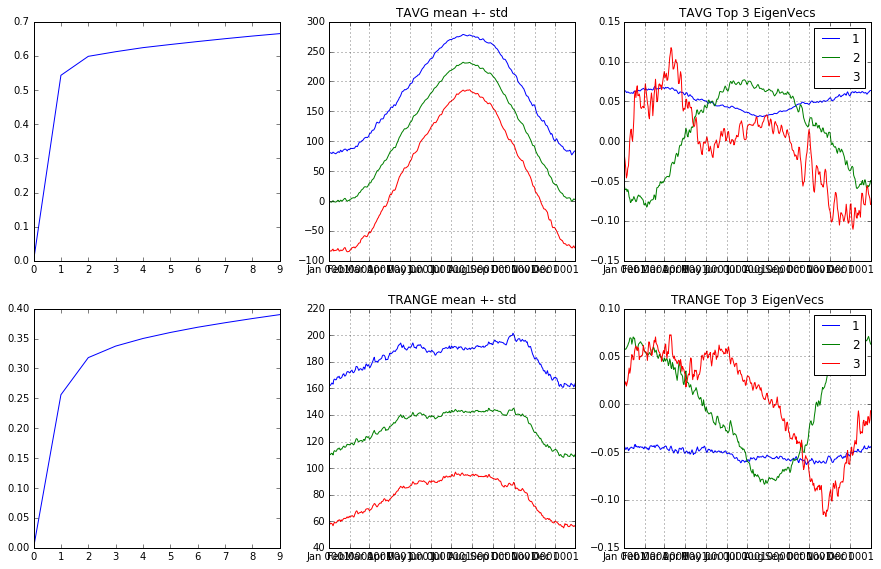

In [17]:
%pylab inline
figure(figsize=(15,30))
offset=1
npa_k = np.arange(10)
for meas in STAT_TAVG_RANGE.keys():
    subplot(6,3,offset)
    offset+=1
    ## Your code for percentage of variance explained
    npa_EigVal = STAT_TAVG_RANGE[meas]['eigval']
    npa_EigVal = sorted(npa_EigVal, reverse=True)
    f_SumVar = sum(npa_EigVal)
    npa_PerVarExplained = zeros(len(npa_k))
    for i in npa_k:
        npa_PerVarExplained[i] = sum(npa_EigVal[0:i])/f_SumVar
    plot(npa_k, npa_PerVarExplained)
    
    subplot(6,3,offset)
    offset+=1
    ## Your code for mean and mean +- std
    YearlyPlots(STAT_TAVG_RANGE[meas]['Mean'] + sqrt(STAT_TAVG_RANGE[meas]['Var']))
    YearlyPlots(STAT_TAVG_RANGE[meas]['Mean'])
    YearlyPlots(STAT_TAVG_RANGE[meas]['Mean'] - sqrt(STAT_TAVG_RANGE[meas]['Var']))
    title('%s mean +- std'%(meas))    
    
    subplot(6,3,offset)
    offset+=1
    ## Your code for top-3 eigenvectors
    YearlyPlots(STAT_TAVG_RANGE[meas]['eigvec'][:,0:3])
    legend([1,2,3])
    title('%s Top 3 EigenVecs'%(meas))    

### Write your answers here

Consult the plots of the eigen-vectors. `SNWD` is available in an earlier notebook.
The statistics for TRANGE and TAVG is in the file
`http://mas-dse-open.s3.amazonaws.com/Weather/STAT_TAVG_RANGE.pickle`

For each of the following eigen-vectors, give a short verbal description

1. TAVG_coeff1: Average temperature across the year.
2. TAVG_coeff2: Difference in temperature between summer and winter.
3. TAVG_coeff3: Difference in temperature between spring and autumn.  
4. TRANGE_coeff1: Average temperature range across the year.
5. TRANGE_coeff2: Difference in temperature range between summer and winter.
6. SNWD_coeff1: Average snow depth across the year.

Once you have given a meaning to each of these eigen-vectors, explain the relation to the input variable. Short explanations are better than long ones.

Example:

1. Locations with high latitude are colder.
2.
3.
4.
5.
6.
7.
8.
9.


1. Locations with high latitude are colder.
2. Locations with high elevation are colder.
3. Locations with big longitude have bigger seasonal weather change.
4. Locations far away from coast have bigger seasonal weather change.
5. Locations with big longitude are hotter, but this effect is relatively small.
6. Locations far away from coast are hotter, but this effect is relatively small.
7. Locations with high elevation have bigger temperature range.
8. Locations with high latitudue have bigger seasonal temperature range.
9. Locations with high latitude snows more and have higher snow depth.